# Design the System Model
Our state variables are: $\begin{bmatrix} SNH_1 \\ SNH_2 \\SHN_3 \\r \end{bmatrix}$

Our input variables are: $\begin{bmatrix} QPE_1 \\ QMLE_2 \\QRAS_3 \\TKN \\SO1 \\SO2 \\SO3 \end{bmatrix}$

Our discrete time state-space model is: 
$$
    \begin{bmatrix}
    SNH_{1,k+1} \\
    SNH_{2,k+1} \\
    SNH_{3,k+1} \\
     r_{k+1}
    \end{bmatrix}  = \frac{1}{V}
    \begin{bmatrix}
    - Q_{T} &&  0  && Q_{MLE} + Q_{RAS} && 0\\
    Q_{T} && -Q_{T} && 0 && 0\\
    0 && Q_{T} && -Q_{T} && 0\\
    0 && 0 && 0 && 0
    \end{bmatrix} 
    \begin{bmatrix}
    SNH_{1,k} \\
    SNH_{2,k} \\
    SNH_{3,k} \\
     r_{k}
    \end{bmatrix}+ \frac{1}{V} \begin{bmatrix}
    Q_{PE}\cdot TKN \cdot a  \\
    0 \\
    0 \\
    0
    \end{bmatrix} + \begin{bmatrix}
    r \cdot \frac{SO_1}{SO_1 + KO_1}  \\
    r\cdot\frac{SNH_2}{SNH_2 + K_{NH}} \cdot \frac{SO_2}{SO_2 + KO_2} \\
    r\cdot\frac{SNH_3}{SNH_3 + K_{NH}} \cdot \frac{SO_3}{SO_3 + KO_3} \\
    0
    \end{bmatrix}
$$

Our Measurement model is:

$$ z = \begin{bmatrix} 0 && 0 &&  1  &&0 \end{bmatrix} \begin{bmatrix}SNH_{1,k+1} \\ SNH_{2,k+1} \\SNH_{3,k+1} \\
     r_{k+1}
    \end{bmatrix} $$  

In [1]:
import sympy
import numpy as np
from IPython.display import display
sympy.init_printing(use_latex='mathjax')


In [2]:
# Define state 
SNH1,SNH2,SNH3,r = sympy.symbols('SNH1 SNH2 SNH3,r')
state = sympy.Matrix([SNH1,SNH2,SNH3,r])

# Define input 
QPE,QRAS,QMLE,TKN,SO1,SO2,SO3 = sympy.symbols('QPE QRAS QMLE TKN SO1 SO2 SO3')
u = sympy.Matrix([QPE,QRAS,QMLE,TKN,SO1,SO2,SO3])

# Define parameters 
V,KNH,KO1,KO2,KO3,fr = sympy.symbols('V KNH KO1 KO2 KO3 fr')
param = sympy.Matrix([V,KNH,KO1,KO2,KO3,fr])

# Define Samping time  
dt = sympy.symbols('dt')

state,u,param,dt
Qtot = QPE + QRAS + QMLE

# Form the dilution matrix
D = sympy.Matrix([[-Qtot,0.,QRAS+QMLE],[Qtot,-Qtot, 0.],[0.,Qtot,-Qtot]])
D = D/V
D = D.row_insert(3,sympy.zeros(1,3))
D = D.col_insert(3,sympy.zeros(4,1))


# Form the TKN feedin matrix 
Feed = sympy.Matrix([[TKN*fr*QPE/V],[0.],[0.],[0.]])
# Form the reaction matrix 
rho = r*sympy.Matrix([SO1/(SO1+KO1),SNH2/(SNH2+KNH)*SO2/(SO2+KO2),SNH3/(SNH3+KNH)*SO3/(SO3+KO3),0])

xdot = D*state + Feed + rho
fxu = xdot*dt + state
F_j = fxu.jacobian(state)
V_j = fxu.jacobian(u)

hx = sympy.Matrix([SNH3])
H_j = hx.jacobian(state)
print("---------------------------f(x,u)--------------------------------------")
print(fxu) # state transition function 
print("---------------------------dfdx----------------------------------------")
print(F_j) # jacobian of state transition function 
print("---------------------------dfdu----------------------------------------")
print(V_j) # jacobian of state transition function 
print("---------------------------dhdx----------------------------------------")
print(H_j) # jacobian of state transition function 

---------------------------f(x,u)--------------------------------------
Matrix([[SNH1 + dt*(QPE*TKN*fr/V + SNH1*(-QMLE - QPE - QRAS)/V + SNH3*(QMLE + QRAS)/V + SO1*r/(KO1 + SO1))], [SNH2 + dt*(SNH1*(QMLE + QPE + QRAS)/V + SNH2*SO2*r/((KNH + SNH2)*(KO2 + SO2)) + SNH2*(-QMLE - QPE - QRAS)/V)], [SNH3 + dt*(SNH2*(QMLE + QPE + QRAS)/V + SNH3*SO3*r/((KNH + SNH3)*(KO3 + SO3)) + SNH3*(-QMLE - QPE - QRAS)/V)], [r]])
---------------------------dfdx----------------------------------------
Matrix([[1 + dt*(-QMLE - QPE - QRAS)/V, 0, dt*(QMLE + QRAS)/V, SO1*dt/(KO1 + SO1)], [dt*(QMLE + QPE + QRAS)/V, dt*(-SNH2*SO2*r/((KNH + SNH2)**2*(KO2 + SO2)) + SO2*r/((KNH + SNH2)*(KO2 + SO2)) + (-QMLE - QPE - QRAS)/V) + 1, 0, SNH2*SO2*dt/((KNH + SNH2)*(KO2 + SO2))], [0, dt*(QMLE + QPE + QRAS)/V, dt*(-SNH3*SO3*r/((KNH + SNH3)**2*(KO3 + SO3)) + SO3*r/((KNH + SNH3)*(KO3 + SO3)) + (-QMLE - QPE - QRAS)/V) + 1, SNH3*SO3*dt/((KNH + SNH3)*(KO3 + SO3))], [0, 0, 0, 1]])
---------------------------dfdu---------------------

In [3]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from copy import deepcopy
class MLEEKF(EKF):
    def __init__(self,M):
        EKF.__init__(self,4,1,7)
        self.dt = 1/144
        self.V = 2000 # initialize constant parameters 
        self.KNH = 0.5
        self.KO1 = 0.6
        self.KO2 = 0.4
        self.KO3 = 0.2 
        self.fr = 0.7 
        self.M = M
    
    ## using the symbolic results above to define state prediction function f(x,u)
    def fxu(self,x,u):
        x =x.reshape(-1)
        dt = self.dt
        V = self.V
        KNH = self.KNH
        KO1 = self.KO1
        KO2 = self.KO2
        KO3 = self.KO3
        fr = self.fr
    
    
        SNH1 = x[0]
        SNH2 = x[1]
        SNH3 = x[2]
        r = x[3]
    
        QPE  = u[0]
        QRAS = u[1]
        QMLE = u[2]
        TKN  = u[3]
    
        SO1 = u[4]
        SO2 = u[5]
        SO3 = u[6]
        x_next = np.array([[SNH1 + dt*(QPE*TKN*fr/V + SNH1*(-QMLE - QPE - QRAS)/V + SNH3*(QMLE + QRAS)/V + SO1*r/(KO1 + SO1))], 
                           [SNH2 + dt*(SNH1*(QMLE + QPE + QRAS)/V + SNH2*SO2*r/((KNH + SNH2)*(KO2 + SO2)) + SNH2*(-QMLE - QPE - QRAS)/V)],
                           [SNH3 + dt*(SNH2*(QMLE + QPE + QRAS)/V + SNH3*SO3*r/((KNH + SNH3)*(KO3 + SO3)) + SNH3*(-QMLE - QPE - QRAS)/V)], 
                           [r]])
        return x_next
        
    ## using the symbolic results above to define jacobian of the state transition function over state,dfdx  
    def F_j(self,x,u):
        x =x.reshape(-1)
        dt = self.dt
        V = self.V
        KNH = self.KNH
        KO1 = self.KO1
        KO2 = self.KO2
        KO3 = self.KO3
        fr = self.fr
    
    
        SNH1 = x[0]
        SNH2 = x[1]
        SNH3 = x[2]
        r = x[3]
    
        QPE  = u[0]
        QRAS = u[1]
        QMLE = u[2]
        TKN  = u[3]
    
        SO1 = u[4]
        SO2 = u[5]
        SO3 = u[6]
        # dFdx should be a 4 by 4 matrix 
        dFdx = np.array([[1 + dt*(-QMLE - QPE - QRAS)/V, 0, dt*(QMLE + QRAS)/V, SO1*dt/(KO1 + SO1)], 
                         [dt*(QMLE + QPE + QRAS)/V, dt*(-SNH2*SO2*r/((KNH + SNH2)**2*(KO2 + SO2)) + SO2*r/((KNH + SNH2)*(KO2 + SO2)) + (-QMLE - QPE - QRAS)/V) + 1, 0, SNH2*SO2*dt/((KNH + SNH2)*(KO2 + SO2))], 
                         [0, dt*(QMLE + QPE + QRAS)/V, dt*(-SNH3*SO3*r/((KNH + SNH3)**2*(KO3 + SO3)) + SO3*r/((KNH + SNH3)*(KO3 + SO3)) + (-QMLE - QPE - QRAS)/V) + 1, SNH3*SO3*dt/((KNH + SNH3)*(KO3 + SO3))],
                         [0, 0, 0, 1]])
        return dFdx
   
    ## using the symbolic results above to define jacobian of the state transition function over input,dfdu
    def V_j(self,x,u):
        x =x.reshape(-1)
        dt = self.dt
        V = self.V
        KNH = self.KNH
        KO1 = self.KO1
        KO2 = self.KO2
        KO3 = self.KO3
        fr = self.fr
    
    
        SNH1 = x[0]
        SNH2 = x[1]
        SNH3 = x[2]
        r = x[3]
    
        QPE  = u[0]
        QRAS = u[1]
        QMLE = u[2]
        TKN  = u[3]
    
        SO1 = u[4]
        SO2 = u[5]
        SO3 = u[6]
        # dFdx should be a 4 by 7 matrix 
        dFdu = np.array([[dt*(-SNH1/V + TKN*fr/V), dt*(-SNH1/V + SNH3/V), dt*(-SNH1/V + SNH3/V), QPE*dt*fr/V, dt*(-SO1*r/(KO1 + SO1)**2 + r/(KO1 + SO1)), 0, 0],
                         [dt*(SNH1/V - SNH2/V), dt*(SNH1/V - SNH2/V), dt*(SNH1/V - SNH2/V), 0, 0, dt*(-SNH2*SO2*r/((KNH + SNH2)*(KO2 + SO2)**2) + SNH2*r/((KNH + SNH2)*(KO2 + SO2))), 0], 
                         [dt*(SNH2/V - SNH3/V), dt*(SNH2/V - SNH3/V), dt*(SNH2/V - SNH3/V), 0, 0, 0, dt*(-SNH3*SO3*r/((KNH + SNH3)*(KO3 + SO3)**2) + SNH3*r/((KNH + SNH3)*(KO3 + SO3)))],
                         [0, 0, 0, 0, 0, 0, 0]])
        return dFdu
    
    def predict(self,u):
        # Project the state ahead
        self.x = self.fxu(self.x,u)
        # Project the error covariance ahead 
        F = self.F_j(self.x,u).astype(float)
        V = self.V_j(self.x,u).astype(float)
        # covariance of motion noise in control space -std of QPE QMLE QRAS QTKN SO1 SO2 SO3
        M = self.M
        self.P = F @ self.P @ F.T + V @ M @ V.T 
        self.P.astype(float)
        
    def HJacobian(self,x):
        return np.array([[0,0,1,0]]) 


    def hx(self,x):
        return x[2]

    def residual(self,a,b):
        return a-b

    def ekf_update(self,z):
        self.update(np.array([z]),HJacobian=self.HJacobian,Hx = self.hx, residual=self.residual )

# Design the measurement model 
The measurement model should be defined by default outside the `MLEEKF` class so that it could passed into the `filterpy.ExtendedKalmanFilter` object.

In our case, since we directly measure the SNH3, therefore, the measurement function and jacobian is the same 

In [4]:
#def HJacobian(x):
#    return np.array([[0,0,1,0]]) 


#def hx(x):
#    return x[2]

#def residual(a,b):
#    return a-b

#def ekf_update(ekf,z):
#    ekf.update(np.array([z]),HJacobian=HJacobian,Hx = hx, residual=residual )

# Test on SUMO data

In [5]:
import pandas as pd
# Process the data from SUMO simulation for testing
Flow_df = pd.read_excel('Closedloop_all_DO_on_eff_SNH.xlsx',sheet_name = 'Influent',usecols = "B,E,F" ,engine='openpyxl',skiprows=4 ,header = None, names =['Time','TKN','QPE'])
DO_df = pd.read_excel('Closedloop_all_DO_on_eff_SNH.xlsx',sheet_name = 'DO',usecols = "B:E" ,engine='openpyxl',skiprows=4 ,header = None, names =['Time','DO1','DO2','DO3'])
output_df = pd.read_excel('Closedloop_all_DO_on_eff_SNH.xlsx',sheet_name = 'SNH',usecols = "B,D:F" ,engine='openpyxl',skiprows=4 ,header = None, names =['Time','SNH1','SNH2','SNH3'])

In [6]:

Flow_df['QRAS'] = 23400
Flow_df['QMLE'] = 36000
input_df = Flow_df.merge(DO_df)
input_df = input_df[['Time','QPE', 'QRAS', 'QMLE','TKN','DO1', 'DO2', 'DO3']]
# Calcualte the input covariance
in_cov = np.array(input_df.cov())[1:8,1:8]
# in_cov[0:5,0:5] = np.eye(5)
# in_cov = np.diag(np.ones(7))
# Create the Extended Kalman Fliter object 
ekf = MLEEKF(in_cov)
# Set the first state guess away from the true value
# ekf.x = np.append(np.array(output_df.iloc[0,1:]),-330)
ekf.x = np.array([0,0,0,-340])
ekf.P = np.diag([10, 10, 10, 70])
ekf.Q = np.diag([1000, 1000, 100, 100])
ekf.R = 0.5
n_samples = Flow_df.shape[0]

track= []
for i in np.arange(1,n_samples):
    u = np.array(input_df.iloc[i,1:])
    # add input noises 
    u = u + 0.1*u*np.random.randn(u.shape[0])
    ekf.predict(u)
    
    z = output_df.iloc[i,3]
    print(type(z),'----before')
    z = z + z*0.1*np.random.randn(1)
    print(type(z),'----after')
    ekf.ekf_update(z)
    track.append(ekf.x)
    

    

<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before

<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before

<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before

<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before

<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after


<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before

<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before
<class 'numpy.ndarray'> ----after
<class 'numpy.float64'> ----before

In [7]:
ekf.x

array([[   6.71477646],
       [   2.53682152],
       [   0.45107725],
       [-338.83245564]])

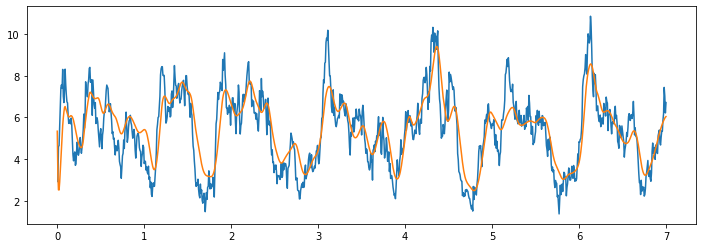

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(output_df.iloc[1:,0],np.array(track)[:,0])
plt.plot(output_df.iloc[:,0],output_df.iloc[:,1])

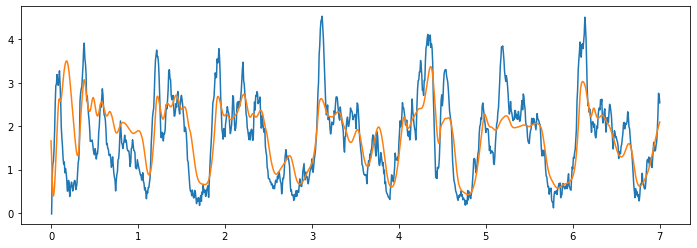

In [9]:
plt.figure(figsize=(12,4))
plt.plot(output_df.iloc[1:,0],np.array(track)[:,1])
plt.plot(output_df.iloc[:,0],output_df.iloc[:,2])

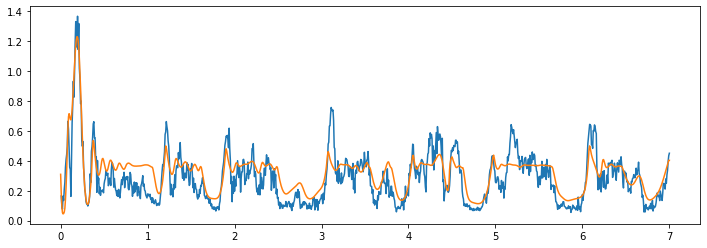

In [10]:
plt.figure(figsize=(12,4))
plt.plot(output_df.iloc[1:,0],np.array(track)[:,2])
plt.plot(output_df.iloc[:,0],output_df.iloc[:,3])

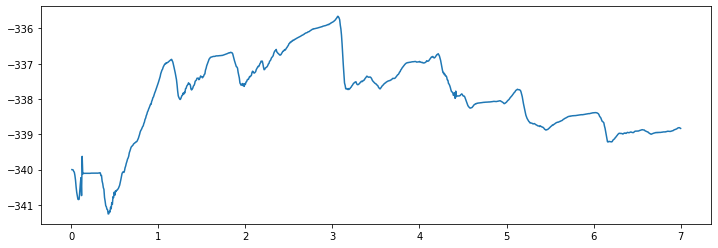

In [11]:
plt.figure(figsize=(12,4))
plt.plot(output_df.iloc[1:,0],np.array(track)[:,3])